In [1]:
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.svm import SVR, SVC
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV

from scipy.stats import expon

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [2]:
# color dict (use: colors['XColor'])

colors = {'DBrwn' : '#8c510a', 'MBrwn' : '#d8b365', 'LBrwn' : '#f6e8c3',
          'DTeal' : '#01665e', 'MTeal' : '#5ab4ac', 'LTeal' : '#c7eae5',
          'DPurp' : '#762a83', 'MPurp' : '#af8dc3', 'LPurp' : '#e7d4e8'
         }

# set params
# save as .mplstyle file and import with: plt.style.use('file')
#mpl.rcParams['lines.linewidth'] = 2
#mpl.rcParams['lines.color'] = 'r'

# colors for seaborn
dark = ["#8c510a", "#01665e", "#762a83"]
med = ["#d8b365", "#5ab4ac", "#af8dc3"]

# Make Predictions wrt Test Set

In [3]:
low_train = '../pkl_trainsets/2jul2018/2jul2018_trainset1_nucs_fissact_not-scaled.pkl'
low_test = '../pkl_trainsets/2jul2018/2jul2018_testset1_nucs_fissact_not-scaled.pkl'
train = '../pkl_trainsets/2jul2018/2jul2018_trainset2_nucs_fissact_not-scaled.pkl'
trainXY = pd.read_pickle(train)
testXY = pd.read_pickle(low_test)

In [4]:
def splitXY(dfXY):
    lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']
    dfX = dfXY.drop(lbls, axis=1)
    if 'total' in dfX.columns:
        dfX.drop('total', axis=1, inplace=True)
    r_dfY = dfXY.loc[:, lbls[0]]
    c_dfY = dfXY.loc[:, lbls[1]]
    e_dfY = dfXY.loc[:, lbls[2]]
    b_dfY = dfXY.loc[:, lbls[3]]
    #o_dfY = dfXY.loc[:, lbls[4]]
    return dfX, r_dfY, c_dfY, e_dfY, b_dfY

trnX, rY, cY, eY, bY = splitXY(trainXY)
tstX, ry, cy, ey, by = splitXY(testXY)    #lowercase Y denotes testing labels

In [5]:
extra = []
for i in trnX.columns:
    if i not in tstX.columns:
        extra.append(i)
print(extra)
trnX = trnX.drop(extra, axis=1)
print(len(trnX.columns))
print(trnX.columns)
print(len(tstX.columns))
print(tstX.columns)

['cs135', 'pd104', 'pd105', 'pd106', 'pu242']
41
Index(['ba138', 'ce140', 'ce142', 'ce144', 'cs133', 'cs137', 'la139', 'mo100',
       'mo95', 'mo97', 'mo98', 'nd143', 'nd144', 'nd145', 'nd146', 'pr141',
       'pu239', 'pu240', 'pu241', 'rb87', 'rh103', 'ru101', 'ru102', 'ru104',
       'sr88', 'sr90', 'tc99', 'u234', 'u235', 'u236', 'u238', 'xe131',
       'xe132', 'xe134', 'xe136', 'y89', 'zr91', 'zr92', 'zr93', 'zr94',
       'zr96'],
      dtype='object')
41
Index(['ba138', 'ce140', 'ce142', 'ce144', 'cs133', 'cs137', 'la139', 'mo100',
       'mo95', 'mo97', 'mo98', 'nd143', 'nd144', 'nd145', 'nd146', 'pr141',
       'pu239', 'pu240', 'pu241', 'rb87', 'rh103', 'ru101', 'ru102', 'ru104',
       'sr88', 'sr90', 'tc99', 'u234', 'u235', 'u236', 'u238', 'xe131',
       'xe132', 'xe134', 'xe136', 'y89', 'zr91', 'zr92', 'zr93', 'zr94',
       'zr96'],
      dtype='object')


In [6]:
#trainX = scale(trnX)
#testX = scale(tstX)

In [57]:
CV=5
for Y in ('r', 'b', 'c', 'e'):
    trainY = pd.Series()
    # get param names and set ground truth
    if Y == 'c':
        trainY = cY
        testY = cy
        parameter = 'cooling'
    elif Y == 'e': 
        trainY = eY
        testY = ey
        parameter = 'enrichment'
    elif Y == 'b':
        trainY = bY
        testY = by
        parameter = 'burnup'
    else:
        trainY = rY
        testY = ry
        parameter = 'reactor'
            
    #######################
    # optimize parameters #
    #######################
            
    # initialize learners
    score = 'explained_variance'
    kfold = KFold(n_splits=CV, shuffle=True)
    knn_init = KNeighborsRegressor(weights='distance')
    rr_init = Ridge()
    svr_init = SVR()
    if Y is 'r':
        score = 'accuracy'
        kfold = StratifiedKFold(n_splits=CV, shuffle=True)
        knn_init = KNeighborsClassifier(weights='distance')
        rr_init = RidgeClassifier(class_weight='balanced')
        svr_init = SVC(class_weight='balanced')
            
    # CV search the hyperparams
    knn_grid = {'n_neighbors': np.linspace(1, 50).astype(int)}
    rr_grid = {'alpha': np.logspace(-4, 10)} 
    svr_grid = {'C': expon(scale=100), 'gamma': expon(scale=.1)}
    knn_opt = RandomizedSearchCV(estimator=knn_init, param_distributions=knn_grid, 
                                 n_iter=20, scoring=score, n_jobs=-1, cv=kfold, 
                                 return_train_score=True)
    rr_opt = RandomizedSearchCV(estimator=rr_init, param_distributions=rr_grid,
                                n_iter=20, scoring=score, n_jobs=-1, cv=kfold, 
                                return_train_score=True)
    svr_opt = RandomizedSearchCV(estimator=svr_init, param_distributions=svr_grid,
                                 n_iter=20, scoring=score, n_jobs=-1, cv=kfold, 
                                 return_train_score=True)
    knn_opt.fit(trainX, trainY)
    rr_opt.fit(trainX, trainY)
    svr_opt.fit(trainX, trainY)

    ## Get best params
    k = knn_opt.best_params_['n_neighbors']
    a = rr_opt.best_params_['alpha']
    g = svr_opt.best_params_['gamma']
    c = svr_opt.best_params_['C']
    print('The {} prediction`s best params are k={}, alpha={}, gamma={}, and C={}\n'.format(parameter, k, a, g, c), flush=True)
    
    ########################
    # run predictions, etc #
    ########################
            
    # gather optimized learners
    knn = knn_opt.best_estimator_
    rr = rr_opt.best_estimator_
    svr = svr_opt.best_estimator_

    scores = ['explained_variance', 'neg_mean_absolute_error']
    if Y is 'r':
        scores = ['accuracy', ]
        
    kpred = knn.predict(testX)
    kscr = knn.score(testX, testY)
    rpred = rr.predict(testX)
    rscr = rr.score(testX, testY)
    spred = svr.predict(testX)
    sscr = svr.score(testX, testY)
    
    print('The {} scores are knn={}, rr={}, and svr={}\n'.format(parameter, kscr, rscr, sscr), flush=True)
    preds_by_alg = pd.DataFrame({'TrueY': testY, 'kNN': kpred, 
                                 'Ridge': rpred, 'SVR': spred}, 
                                 index=testY.index)
    preds_by_alg.to_csv('testset1_v_trainset2_' + parameter + '_predictions.csv')

The reactor prediction`s best params are k=2, alpha=0.0001, gamma=0.35221304975892875, and C=170.76319679520492

The reactor scores are knn=0.48314606741573035, rr=0.20224719101123595, and svr=0.48314606741573035

The burnup prediction`s best params are k=1, alpha=0.0003727593720314938, gamma=0.06697002148601283, and C=313.14668957549054

The burnup scores are knn=-39.16805176383422, rr=-45.42256452687642, and svr=-26.056543408781234

The cooling prediction`s best params are k=3, alpha=0.0001, gamma=0.22508692714549255, and C=298.8608348058083

The cooling scores are knn=-48.78019331791493, rr=-74.00634398388814, and svr=-11.078454053258973

The enrichment prediction`s best params are k=9, alpha=0.0001, gamma=0.1822108266740316, and C=117.87275214156938

The enrichment scores are knn=-0.5639385068903255, rr=-75.31628685015247, and svr=-36.643366260200715



## Lowburn data set

In [71]:
# predictions
low_rxtr = pd.read_csv('./testset1_v_trainset1_reactor_predictions.csv').rename(columns = {'Unnamed: 0':'Instance'})
# MWd/MTU
low_burn = pd.read_csv('./testset1_v_trainset1_burnup_predictions.csv').rename(columns = {'Unnamed: 0':'Instance'})
# %u235
low_enri = pd.read_csv('./testset1_v_trainset1_enrichment_predictions.csv').rename(columns = {'Unnamed: 0':'Instance'})
# days
low_cool = pd.read_csv('./testset1_v_trainset1_cooling_predictions.csv').rename(columns = {'Unnamed: 0':'Instance'})

knn = 'kNN'
rr = 'Ridge'
svr = 'SVR'
Y = 'TrueY'

In [72]:
low_burn = low_burn.filter(items=[knn, rr, svr, Y])//1000
low_cool = low_cool.filter(items=[knn, rr, svr, Y])//30
low_enri = low_enri.filter(items=[knn, rr, svr, Y])

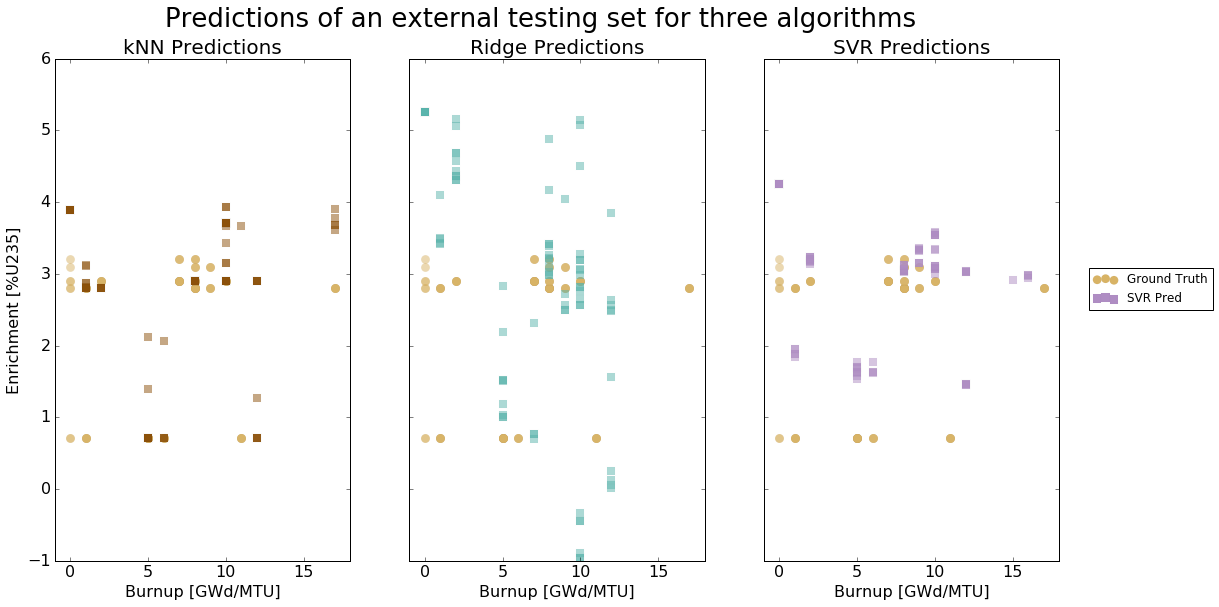

In [36]:
#fig.clf()

fig, (ax_knn, ax_rr, ax_svr) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(18, 9))
ax_knn.set_ylabel('Enrichment [%U235]', fontsize=16)
#plt.ylim(0, 6.2)

ax_knn.set_xlabel('Burnup [GWd/MTU]', fontsize=16)
ax_knn.set_xlim(-1, 18)
ax_knn.set_ylim(-1, 6)
ax_knn.tick_params(labelsize=16)

ax_rr.set_xlabel('Burnup [GWd/MTU]', fontsize=16)
ax_rr.set_xlim(-1, 18)
ax_rr.set_ylim(-1, 6)
ax_rr.tick_params(labelsize=16)

ax_svr.set_xlabel('Burnup [GWd/MTU]', fontsize=16)
ax_svr.set_xlim(-1, 18)
ax_svr.set_ylim(-1, 6)
ax_svr.tick_params(labelsize=16)

# GROUND TRUTHS
ax_knn.scatter(low_burn[[Y]], low_enri[[Y]], c='k', s=75, alpha=0.5, linewidths=0.01, marker='o', label='Ground Truth')
ax_rr.scatter(low_burn[[Y]], low_enri[[Y]], c='k', s=75, alpha=0.5, linewidths=0.01, marker='o', label='Ground Truth')
ax_svr.scatter(low_burn[[Y]], low_enri[[Y]], c='k', s=75, alpha=0.5, linewidths=0.01, marker='o', label='Ground Truth')

# PREDICTIONS
ax_knn.scatter(low_burn[[knn]], low_enri[[knn]], c=colors['DBrwn'], s=75, alpha=0.5, linewidths=0.01, marker='s', label='kNN Pred')
ax_rr.scatter(low_burn[[rr]], low_enri[[rr]], c=colors['MTeal'], s=75, alpha=0.5, linewidths=0.01, marker='s', label='Ridge Pred')
ax_svr.scatter(low_burn[[svr]], low_enri[[svr]], c=colors['MPurp'], s=75, alpha=0.5, linewidths=0.01, marker='s', label='SVR Pred')

ax_knn.set_title('kNN Predictions', fontsize=20)
ax_rr.set_title('Ridge Predictions', fontsize=20)
ax_svr.set_title('SVR Predictions', fontsize=20)
leg = fig.legend(loc=(1.1, 0.5))
for l in leg.legendHandles:
    l.set_alpha(1)
plt.suptitle('Predictions of an external testing set versus ground truth', fontsize=26)
#fig.savefig('../results/21jul2018/graphs/1preds-versus-trueY.png', bbox_inches='tight', transparent=True)
plt.show()

## SFCOMPO data set

In [74]:
# predictions
rxtr = pd.read_csv('./testset1_v_trainset2_reactor_predictions.csv').rename(columns = {'Unnamed: 0':'Instance'})
# MWd/MTU
burn = pd.read_csv('./testset1_v_trainset2_burnup_predictions.csv').rename(columns = {'Unnamed: 0':'Instance'})
# %u235
enri = pd.read_csv('./testset1_v_trainset2_enrichment_predictions.csv').rename(columns = {'Unnamed: 0':'Instance'})
# days
cool = pd.read_csv('./testset1_v_trainset2_cooling_predictions.csv').rename(columns = {'Unnamed: 0':'Instance'})

In [75]:
enri.head()

,Instance,Ridge,SVR,TrueY,kNN
0,0.000e+00,-7.493832,-1.706075,2.8,2.833310
1,5.313e+01,-0.100807,3.859430,2.8,4.000000
2,6.012e+01,-1.236978,3.815692,2.8,4.000000
3,8.312e+01,-2.703789,3.455543,2.8,3.888925
4,4.184e+02,-2.720775,2.862924,2.8,3.667022


In [76]:
burn = burn.filter(items=[knn, rr, svr, Y])//1000
cool = cool.filter(items=[knn, rr, svr, Y])//30
enri = enri.filter(items=[knn, rr, svr, Y])

In [78]:

enri.head()


,kNN,Ridge,SVR,TrueY
0,2.833310,-7.493832,-1.706075,2.8
1,4.000000,-0.100807,3.859430,2.8
2,4.000000,-1.236978,3.815692,2.8
3,3.888925,-2.703789,3.455543,2.8
4,3.667022,-2.720775,2.862924,2.8


TypeError: legend() missing 2 required positional arguments: 'handles' and 'labels'

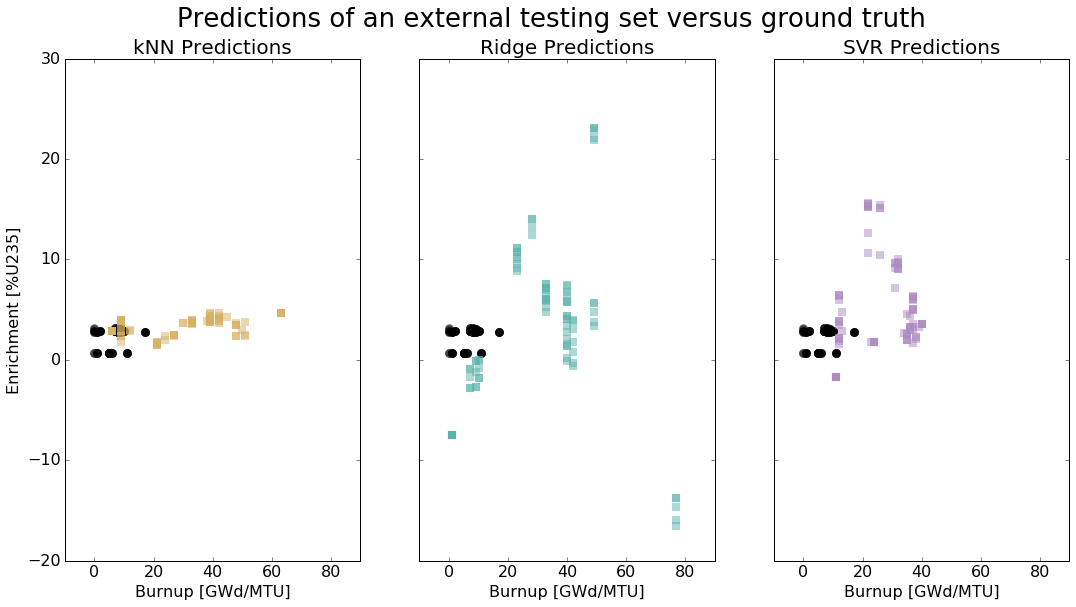

In [80]:
fig.clf()

fig, (ax_knn, ax_rr, ax_svr) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(18,9))
#plt.xlim(-1, 18)
#plt.ylim(0, 6)
ax_knn.set_xlabel('Burnup [GWd/MTU]', fontsize=16)
ax_rr.set_xlabel('Burnup [GWd/MTU]', fontsize=16)
ax_svr.set_xlabel('Burnup [GWd/MTU]', fontsize=16)
ax_knn.set_ylabel('Enrichment [%U235]', fontsize=16)

ax_knn.tick_params(labelsize=16)
ax_rr.tick_params(labelsize=16)
ax_svr.tick_params(labelsize=16)

# GROUND TRUTHS
ax_knn.scatter(burn[[Y]], enri[[Y]], c='k', s=75, alpha=0.5, linewidths=0.01, marker='o', label='Ground Truth')
ax_rr.scatter(burn[[Y]], enri[[Y]], c='k', s=75, alpha=0.5, linewidths=0.01, marker='o', label='Ground Truth')
ax_svr.scatter(burn[[Y]], enri[[Y]], c='k', s=75, alpha=0.5, linewidths=0.01, marker='o', label='Ground Truth')

# PREDICTIONS
ax_knn.scatter(burn[[knn]], enri[[knn]], c=colors['MBrwn'], s=75, alpha=0.5, linewidths=0.01, marker='s', label='kNN Pred')
ax_rr.scatter(burn[[rr]], enri[[rr]], c=colors['MTeal'], s=75, alpha=0.5, linewidths=0.01, marker='s', label='Ridge Pred')
ax_svr.scatter(burn[[svr]], enri[[svr]], c=colors['MPurp'], s=75, alpha=0.5, linewidths=0.01, marker='s', label='SVR Pred')

ax_knn.set_title('kNN Predictions', fontsize=20)
ax_rr.set_title('Ridge Predictions', fontsize=20)
ax_svr.set_title('SVR Predictions', fontsize=20)
plt.suptitle('Predictions of an external testing set versus ground truth', fontsize=26)
leg = fig.legend(loc=(1.1, 0.5))
for l in leg.legendHandles:
    l.set_alpha(1)
#fig.savefig('../results/21jul2018/graphs/2preds-versus-trueY.png', bbox_inches='tight', transparent=True)
plt.show()

# Prediction Visualization (vs Ground Truth)

## Low burnup data set

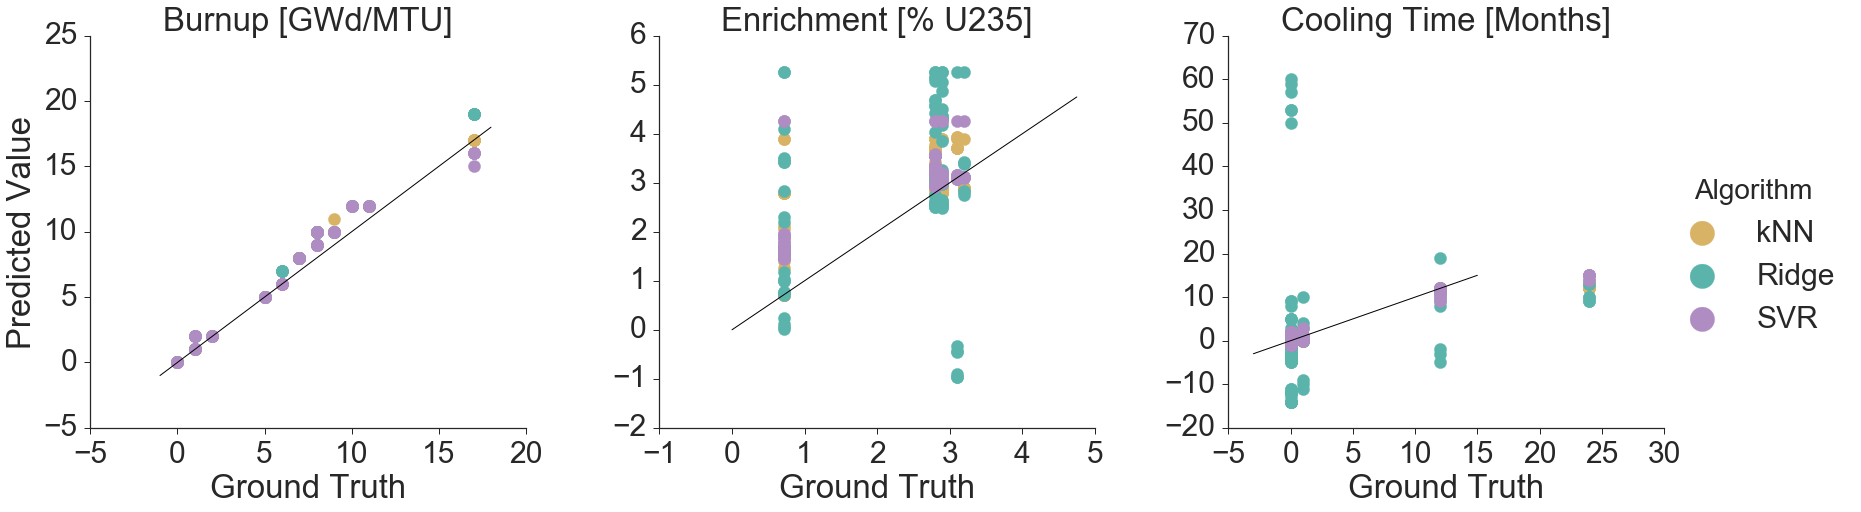

In [81]:
plt.clf()
sns.set(style="ticks", font_scale=3.0)

low_burn['Parameter'] = 'Burnup [GWd/MTU]'
low_enri['Parameter'] = 'Enrichment [% U235]'
low_cool['Parameter'] = 'Cooling Time [Months]'

pred_df = pd.DataFrame()
pred_df = pd.concat([low_burn, low_enri, low_cool])
pred_df = pred_df.melt(id_vars = ['TrueY', 'Parameter'], 
                       value_vars = ['kNN', 'Ridge', 'SVR'], 
                       value_name='Predicted Value', var_name='Algorithm')
pred = sns.FacetGrid(data=pred_df, col="Parameter",
                     hue="Algorithm", 
                     sharex=False, sharey=False, size=8, 
                     palette=sns.color_palette(med))
pred= pred.map(plt.scatter, 'TrueY', 'Predicted Value', s=150)

(pred.set_axis_labels("Ground Truth", "Predicted Value")
     .set_titles("{col_name}")
     .add_legend(markerscale=2))
#pred.axes[0,0].set_ylim(-1, 18)
#pred.axes[0,0].set_xlim(-1, 18)
pred.axes[0,0].plot([-1, 18], [-1, 18], 'k-', linewidth=1)
#pred.axes[0,1].set_ylim(0, 4.75)
#pred.axes[0,1].set_xlim(0, 4.75)
pred.axes[0,1].plot([0, 4.75], [0, 4.75], 'k-', linewidth=1)
#pred.axes[0,2].set_ylim(-3, 15)
#pred.axes[0,2].set_xlim(-3, 15)
pred.axes[0,2].plot([-3, 15], [-3, 15], 'k-', linewidth=1)

#pred.savefig('../results/21jul2018/graphs/1preds-versus-trueY-detailed.png', bbox_inches='tight', transparent=True)

## SFCOMPO data set

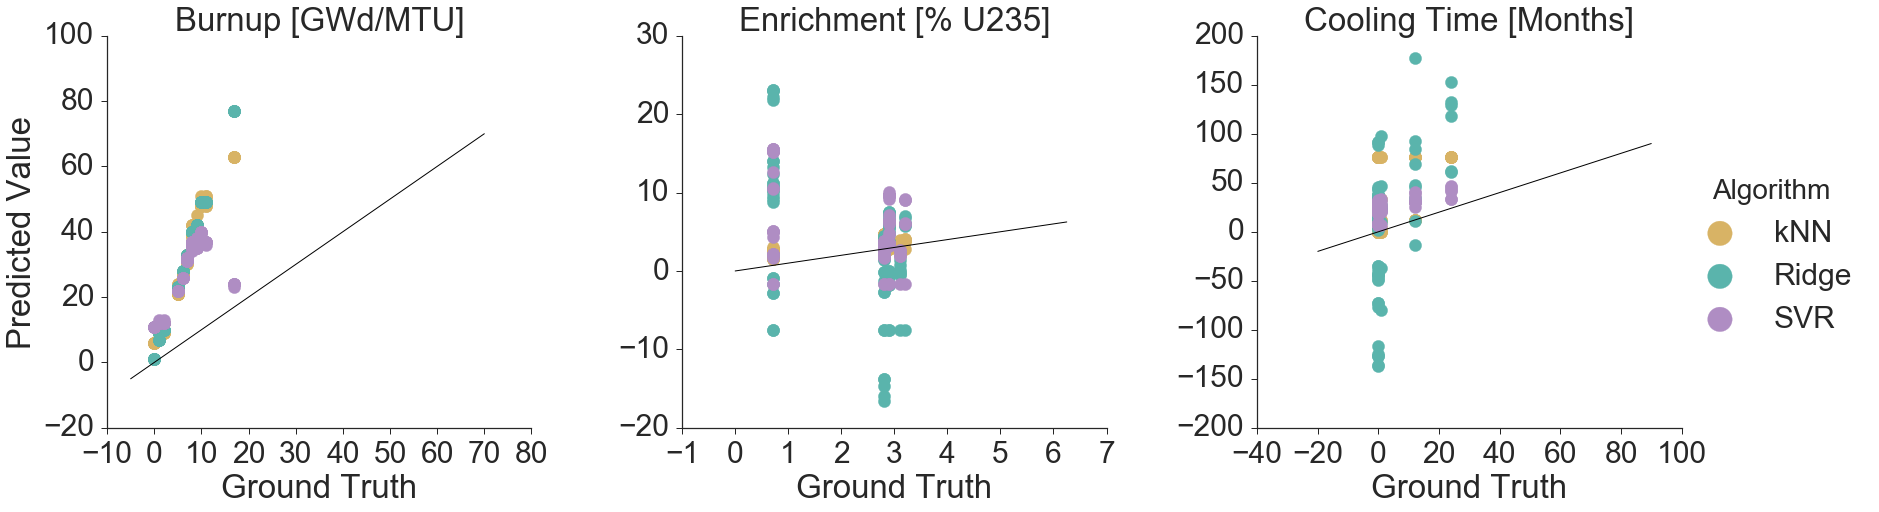

In [82]:
plt.clf()
sns.set(style="ticks", font_scale=3.0)

burn['Parameter'] = 'Burnup [GWd/MTU]'
enri['Parameter'] = 'Enrichment [% U235]'
cool['Parameter'] = 'Cooling Time [Months]'

pred_df = pd.DataFrame()
pred_df = pd.concat([burn, enri, cool])
pred_df = pred_df.melt(id_vars = ['TrueY', 'Parameter'], 
                       value_vars = ['kNN', 'Ridge', 'SVR'], 
                       value_name='Predicted Value', var_name='Algorithm')
pred = sns.FacetGrid(data=pred_df, col="Parameter",
                     hue="Algorithm", 
                     sharex=False, sharey=False, size=8, 
                     palette=sns.color_palette(med))
pred= pred.map(plt.scatter, 'TrueY', 'Predicted Value', s=150)

(pred.set_axis_labels("Ground Truth", "Predicted Value")
     .set_titles("{col_name}")
     .add_legend(markerscale=2))
#pred.axes[0,0].set_ylim(-5, 70)
#pred.axes[0,0].set_xlim(-5, 70)
pred.axes[0,0].plot([-5, 70], [-5, 70], 'k-', linewidth=1)
#pred.axes[0,1].set_ylim(0, 6.25)
#pred.axes[0,1].set_xlim(0, 6.25)
pred.axes[0,1].plot([0, 6.25], [0, 6.25], 'k-', linewidth=1)
#pred.axes[0,2].set_ylim(-20, 90)
#pred.axes[0,2].set_xlim(-20, 90)
pred.axes[0,2].plot([-20, 90], [-20, 90], 'k-', linewidth=1)

#pred.savefig('../results/21jul2018/graphs/2preds-versus-trueY-detailed.png', bbox_inches='tight', transparent=True)

# NOTES

for predictions in both training sets, burnup is good, and the others are bad

the validation and learning curves were (and thus alg hyperparams) were optimized for burnup only, need to do this separately for each prediction

may need to just run hyperparam optimization for each alg (knn, rr, svr) each time before prediction. 
Variables include: 
- trainset (1 or 2)
- nuclide subset (fiss, act, fissact, top_n)
- parameter being predicted (rxtr, burn, enri, cooling)
- scoring metric (exp var for diagnostic curves now, but also r2, RMSE, MAE)
